GPU: 0
# dim z: 20
# Minibatch-size: 1200
# epoch: 10

(60000, 1, 28, 28)
(60000, 1, 28, 28)
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           372.703     348.897               371.691        348.893                   6.61502       
2           347.335     348.893               347.333        348.893                   11.1656       
3           347.334     348.893               347.333        348.892                   15.7542       
4           347.334     348.893               347.333        348.892                   20.3896       
5           347.334     348.893               347.333        348.892                   25.0504       
6           347.333     348.893               347.333        348.892                   29.7534       
7           347.333     348.893               347.333        348.892                   34.4542       
8           347.333     348.893               347.333        348.892                   39.160

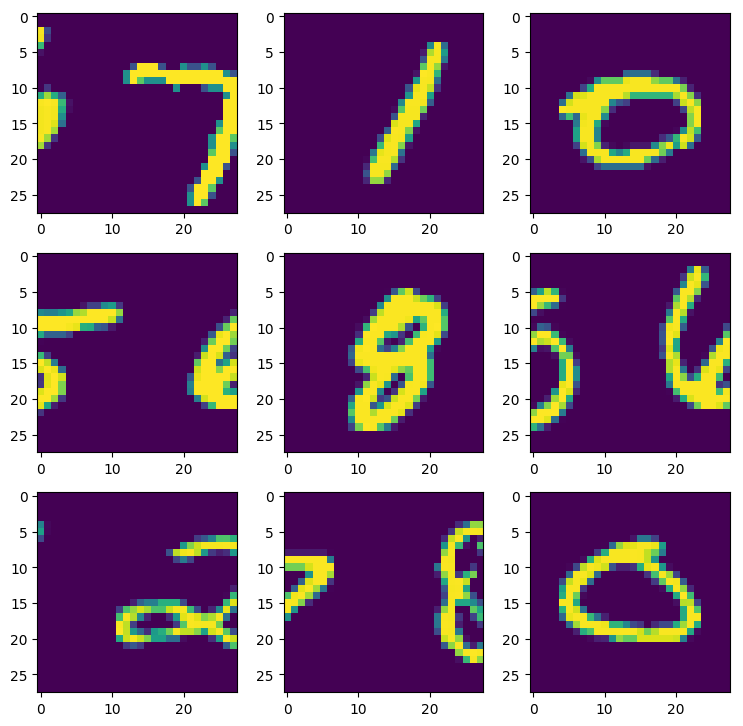

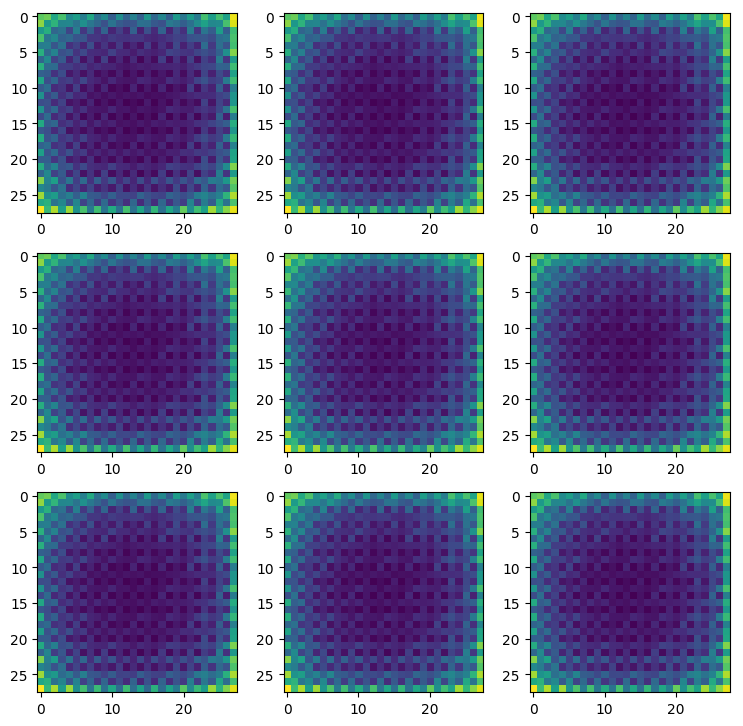

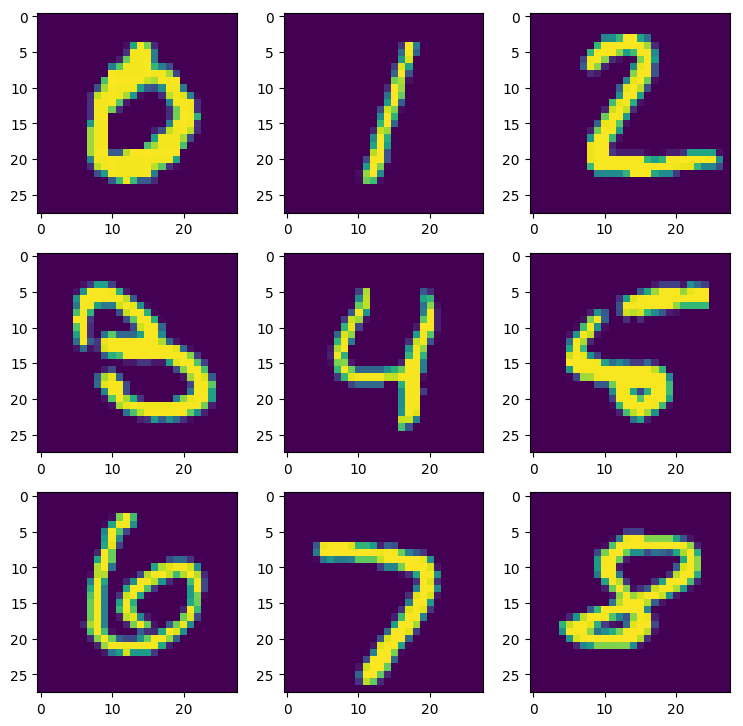

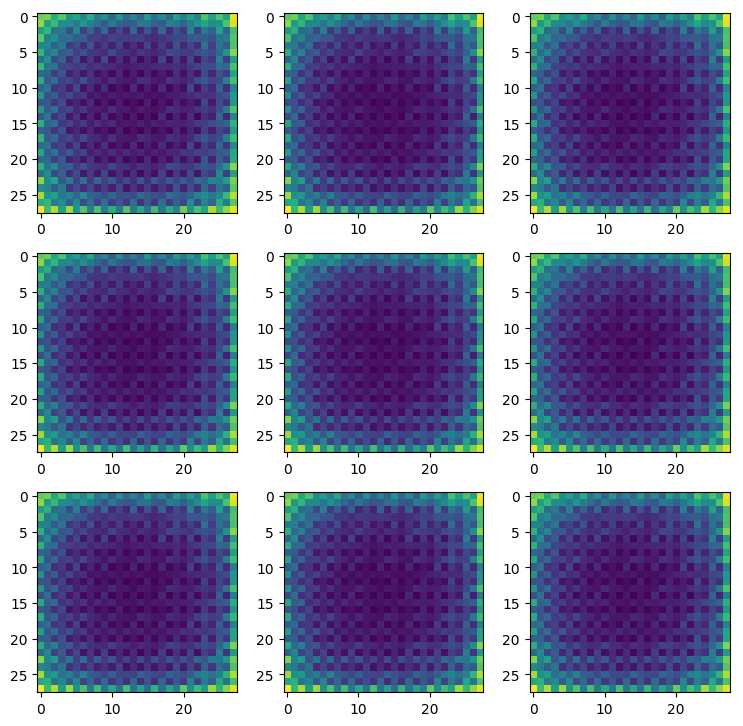

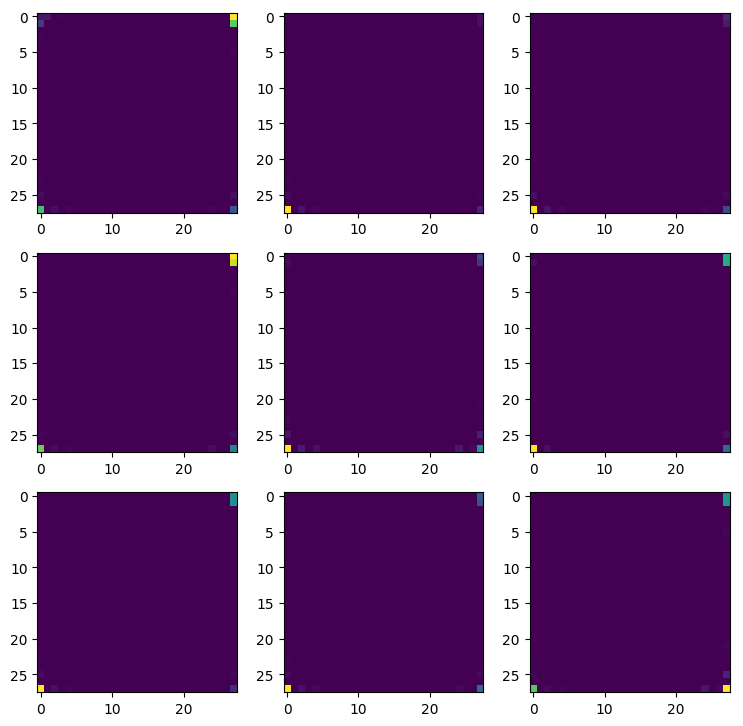

In [1]:
#!/usr/bin/env python
"""Chainer example: train a VAE on MNIST
"""
import argparse
import os

import chainer
from chainer import training
from chainer.training import extensions
import numpy as np

import net
import make_random_mnist
import pickle

def load_random_dataset_nolabel():
    with open('random_dataset.pickle', mode='rb') as f:
        ret = pickle.load(f)
        return ret

def save_random_dataset_nolabel(v):
    with open('random_dataset.pickle', mode='wb') as f:
        pickle.dump(v, f)
        
def main():
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=10, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=20, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=1200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args = ['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    # Prepare VAE model, defined in net.py
    model = net.conv_VAE(1, args.dimz, 20)
    #model = net.VAE(28*28, args.dimz, 20)

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if args.initmodel:
        chainer.serializers.load_npz(args.initmodel, model)

    # Load the MNIST dataset
    train, test = chainer.datasets.get_mnist(withlabel=False)
    dataset = make_random_mnist.MakeRandomMNIST()
    train = dataset.get_random_dataset_nolabel(60000)
    #'''
    train = np.reshape(train,(len(train),28, 28, 1))
    train = train.transpose(0,3,1,2)
    
    test = np.reshape(test,(len(test),28, 28, 1))
    test = test.transpose(0,3,1,2)
    #'''    
    #save_random_dataset_nolabel(train)
    #train = load_random_dataset_nolabel()
    print(train.shape)
    #train = np.reshape(train,(len(train),28, 28, 1))
    #train = train.transpose(0,3,1,2)
    
    
    print(train.shape)

    if args.test:
        train, _ = chainer.datasets.split_dataset(train, 100)
        test, _ = chainer.datasets.split_dataset(test, 100)

    train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                                 repeat=False, shuffle=False)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer,
        device=args.gpu, loss_func=model.get_loss_func())
    #updater = training.updaters.ParallelUpdater(train_iter, optimizer, devices={'main': 0, 'second': 1})

    trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu,
                                        eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(args.epoch, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if args.resume:
        chainer.serializers.load_npz(args.resume, trainer)

    # Run the training
    trainer.run()

    # Visualize the results
    def save_images(x, filename):
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
        for ai, xi in zip(ax.flatten(), x):
            ai.imshow(xi.reshape(28, 28))
        fig.savefig(filename)

    model.to_cpu()
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    x = chainer.Variable(np.asarray(train[train_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'train'))
    save_images(x1.data, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    x = chainer.Variable(np.asarray(test[test_ind]))
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        x1 = model.decode(model.encode(x)[0])
    save_images(x.data, os.path.join(args.out, 'test'))
    save_images(x1.data, os.path.join(args.out, 'test_reconstructed'))

    # draw images from randomly sampled z
    z = chainer.Variable(
        np.random.normal(0, 1, (9, args.dimz)).astype(np.float32))
    x = model.decode(z)
    save_images(x.data, os.path.join(args.out, 'sampled'))


if __name__ == '__main__':
    main()
